# **Nuwe - Summer Coding League**
# Week  1 - Predicting Cardano price movements

Author: Carlos Pérez Ricardo

# Problem definition

[Cardano](https://cardano.org/) is one of the most important cryptocurrencies in the [cryptocurrency market](https://coinmarketcap.com/), and it is also one of the most volatile in the top 10. Currently the cryptocurrency market is a highly speculative market in which there are large players who are making large profits through the use of bots that buy and sell when they detect anomalous movements, and who benefit from the high volatility in prices, the more volatility there is, the higher the profit margins obtained. As this is a market in which the majority of large movements are made by bots, it is not unreasonable to think that bots can be used with just a few pieces of market data to detect price trigger actions and take advantage of them.


---
## Task

Create a predictive algorithm (Machine Learning or Deep Learning) to predict the correct time to buy cardano and the correct time to sell, these are defined by the 'target' column of the 'train.csv' dataset. Once the predictive algorithm is done, it has to be used with the testing predictors dataset. 

--- 
## Dataset

For this challenge two [datasets](https://github.com/nuwe-io/SCL/tree/main/data_science/week_1) are provided, the dataset for training the predictive algorithm and the dataset for testing the predictive algorithm.

Each row of the dataset represents features of the trades done in periods of 5 minutes. The train + test dataset contains information of the pair ADA/USDT of 63 days obtained by using the Binance API.

### train.csv
*Shape (12701 rows, 11 columns)*

| Open_time           | Open   | High   | Low    | Close  | Volume     | QV           | NOT  | TBB        | TBQ          | Volatility | target |
|---------------------|--------|--------|--------|--------|------------|--------------|------|------------|--------------|------------|--------|
| 2021-05-13 09:00:00 | 1.6625 | 1.6800 | 1.6623 | 1.6737 | 2878032.99 | 4.821304e+06 | 5125 | 1702161.28 | 2.851617e+06 | 0.673684   | 0      |

#### Predictors
First 10 columns

* **Open_time** -> Time in which the candle starts. ('%Y-%m-%d %H:%M:%S')
* **Open** -> Open price of the candle, (price of the asset at the beggining of the 5 minutes)
* **High** -> Higher price of the asset in the 5 minutes period
* **Low** -> Lower price of the asset in the 5 minutes period
* **Close** -> Close price of the candle (price of the asset at the end of the 5 minutes)

![](https://github.com/nuwe-io/SCL/blob/main/data_science/week_1/images/candle.png)

* **Volume** -> Amount of cryptocurrecies transactionated in the 5 minutes timeframe
* **QV** -> Quote asset Volume, amount of USD transactionated in the 5 minutes timeframe
* **NOT** -> Number Of Trades, this mean the total number of transactions done in the 5 minutes timeframe
* **TBB** -> (Taker Buy Base) Amount of crypto bought directly with a market order
* **TBQ** -> (Taker Buy Quote) Amount of USDT bought directly with a maket order
* **Volatility** -> Is the relative change between the close price and the open price of each timeframe [%] 


#### Target
Column 11 -> target to predict 

This column shows 3 values that goes from 0 to 2. Where each of these values corresponds to one order. These orders can be later be executed by a bot

| Value | Order |
|:-----:|:-----:|
|   0   |  Wait |
|   1   |  Buy  |
|   2   |  Sell |


### test_predictors.csv
*Shape (5443 rows, 10 columns)*

Contains the same predictors as in the train set to test the accuracy of your predictive algorithm.

# Solution to the problem

This problem is an imbalanced multiclass classification problem where the target is composed by 3 classes (0 = wait, 1 = buy, 2 = sell). 

Deep Learning is commonly used with problems in the finance or cryptomarket fields. For this problem we will give a try to [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) (Long short-term memory) which is an artificial recurrent neural network (RNN) architecture. 

LSTMs are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. 

And as this problem has an important issue with Time Series, let's see how it performs!

**Importing libraries and dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import time

import keras
from tensorflow import keras as ks

from keras.layers import TimeDistributed
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.callbacks import ModelCheckpoint

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nuwe-io/SCL/main/data_science/week_1/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/nuwe-io/SCL/main/data_science/week_1/test_predictors.csv')

As explained before, the dataset is composed of 11 columns and the last one corresponds to the target. The test dataset lacks the target column. 

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12701 entries, 0 to 12700
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open_time   12701 non-null  object 
 1   Open        12701 non-null  float64
 2   High        12701 non-null  float64
 3   Low         12701 non-null  float64
 4   Close       12701 non-null  float64
 5   Volume      12701 non-null  float64
 6   QV          12701 non-null  float64
 7   NOT         12701 non-null  int64  
 8   TBB         12701 non-null  float64
 9   TBQ         12701 non-null  float64
 10  Volatility  12701 non-null  float64
 11  target      12701 non-null  int64  
dtypes: float64(9), int64(2), object(1)
memory usage: 1.2+ MB


In [4]:
df_train.head(5)

,Open_time,Open,High,Low,Close,Volume,QV,NOT,TBB,TBQ,Volatility,target
0,2021-05-13 09:00:00,1.6625,1.6800,1.6623,1.6737,2878032.99,4.821304e+06,5125,1702161.28,2.851617e+06,0.673684,0
1,2021-05-13 09:05:00,1.6738,1.6790,1.6686,1.6733,2723854.15,4.558141e+06,4318,1516726.12,2.538139e+06,-0.029872,0
2,2021-05-13 09:10:00,1.6734,1.6749,1.6496,1.6514,3653708.06,6.075417e+06,5561,1625405.03,2.702822e+06,-1.314689,1
3,2021-05-13 09:15:00,1.6515,1.6708,1.6500,1.6693,3313388.75,5.505110e+06,5374,1797877.23,2.987432e+06,1.077808,0
4,2021-05-13 09:20:00,1.6690,1.6728,1.6587,1.6668,3478711.17,5.794350e+06,5799,1736515.81,2.892649e+06,-0.131815,0


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5443 entries, 0 to 5442
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open_time   5443 non-null   object 
 1   Open        5443 non-null   float64
 2   High        5443 non-null   float64
 3   Low         5443 non-null   float64
 4   Close       5443 non-null   float64
 5   Volume      5443 non-null   float64
 6   QV          5443 non-null   float64
 7   NOT         5443 non-null   int64  
 8   TBB         5443 non-null   float64
 9   TBQ         5443 non-null   float64
 10  Volatility  5443 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 467.9+ KB


## Analisis of the target

The target is a little unbalanced, in most of the timestamps the target is 0 (wait). So if the model provides the default and most common answer, the accuracy would be 0.93748. 

So our model would have provide a better result, than saying default. 

Guessing all 0 doesn't make sense, the goal of this task is to provide an algotithm that can find patterns in order to buy or sell Cardano stocks.

Due to the imbalance of the dataset, we will perform a Synthetic Minority Oversampling Technique ([SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)).


In [6]:
df_train['target'].value_counts()

0    11097
2      802
1      802
Name: target, dtype: int64

In [7]:
labels = to_categorical(df_train['target'], num_classes=3)

In [8]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

# Data Preparation

In this part we extract all useful information and leave every column as a number (Deep Learning work only with matrices of numbers).

The main issue is to extract all useful information from the timestamp "Open_time".

In [9]:
def convert_time(df):

  df = df.sort_values('Open_time')

  df['Year'] = [int(x[:4]) for x in df['Open_time'] ]
  df['Month'] = [int(x[5:7]) for x in df['Open_time'] ]
  df['Day'] = [int(x[8:11]) for x in df['Open_time'] ]

  df['Hour'] = [int(x[11:13]) for x in df['Open_time'] ]
  df['Minute'] = [int(x[14:16]) for x in df['Open_time'] ]

  df['Open_time'] = [time.mktime(time.strptime(x, "%Y-%m-%d %H:%M:%S")) for x in df['Open_time'] ]

  return df

In [10]:
df_train = convert_time(df_train)
df_test = convert_time(df_test)

In [11]:
cols = df_train.columns
cols = cols.drop("target")

X_train = df_train[cols]
y_train = df_train["target"]

We perform a SMOTE with the goal of having a final target distribution of  {0:20000, 1:5000, 2:5000}. Where the key corresponds to the class and the value to the number of samples. 

This way we ensure to have a balanced dataset, and the model would not try always to predict 0, as it is the most common answer (and as it provides a very high accuracy).

And we also scale the features with a MinMaxScaler, that fits all variables between 0 and 1. 

In [12]:
# transform the dataset
#strategy = {0:15000, 1:10000, 2:10000}
strategy = {0:20000, 1:5000, 2:5000}
oversample = SMOTE(sampling_strategy=strategy)

#X_train_over, y_train_over = X_train, y_train
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

y_train_over = to_categorical(y_train_over, num_classes=3)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (20000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 11097)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=Future

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()

X_train_over = scaler.fit_transform(X_train_over)
#X_train_over = X_train_over.copy()

X_test = scaler.fit_transform(df_test)

In [14]:
pd.DataFrame(y_train_over).value_counts()

0    1    2  
1.0  0.0  0.0    20000
0.0  1.0  0.0     5000
     0.0  1.0     5000
dtype: int64

The next step is to prepare the dataset for the LSTM. The LSTM receives a matrix with the following shape: [samples, timesteps, features].

We would work with 20 timesteps, so with the reshape this means in 1500 samples and the number of features is 16. 

Timesteps enable the LSTM to take into account what have happen previously and remember or consider it in order to predict the following instance. 

In [15]:
#[samples, timesteps, features].
timesteps = 20
samples = int(X_train_over.shape[0]/timesteps)
features = len(cols)

X_train_reshape = np.array(X_train_over).reshape(samples, timesteps, features)
y_train_reshape = np.array(y_train_over).reshape(samples, timesteps, 3)
X_train_reshape.shape

(1500, 20, 16)

In [16]:
y_train_reshape

array([[[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]],

       ...,

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]], dtype=float32)

# Model construction

In this part the Neural Network is built. The first layer is a Sequential and the following is the LSTM. 

The last layer is also a Dense but with 3 outputs and the activation function is softmax as the output is multiclass. 

Moreover, the model loss function is the categorical_crossentropy and the selected optimizer is Adam. The metrics to track would be loss and accuracy.

In [17]:
model = Sequential()
model.add(LSTM(500, dropout=0.25, input_shape=( timesteps, features ),return_sequences=True))

model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 500)           1034000   
_________________________________________________________________
dense (Dense)                (None, 20, 3)             1503      
Total params: 1,035,503
Trainable params: 1,035,503
Non-trainable params: 0
_________________________________________________________________


We create a callback to store the best model found in every epoch, so we don't lose it and can use it after the training. 

In [18]:
checkpoint_filepath = 'model.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
X_train_orig = scaler.fit_transform(X_train[:-1])
y_train_orig = to_categorical(y_train[:-1], num_classes=3)

In [20]:
timesteps = 20
samples = int(X_train_orig.shape[0]/timesteps)
features = len(cols)

X_train_orig_reshape = np.array(X_train_orig).reshape(samples, timesteps, features)
y_train_orig_reshape = np.array(y_train_orig).reshape(samples, timesteps, 3)
X_train_orig_reshape.shape

(635, 20, 16)

We will use the new balanced training set to fit the model and the original training set to validate the model. 

We now wait for the model to fit. Note that the accuracy we obtain is not the real accuracy as we have oversampled the dataset, the val_accuracy is the real accuracy.

The oversample is done in order to allow the model to see more unbalanced classes so it can classify them better. 

In [21]:
history = model.fit(X_train_reshape, y_train_reshape, epochs=3000, batch_size=512, verbose=0, callbacks=[model_checkpoint_callback],
          validation_data=(X_train_orig_reshape, y_train_orig_reshape))

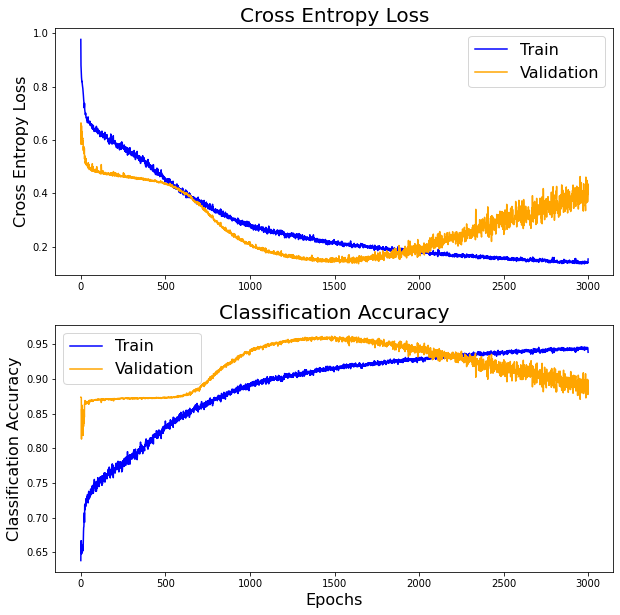

In [22]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].set_title('Cross Entropy Loss', fontsize = 20)
ax[0].plot(history.history['loss'], color='blue', label='Train')
ax[0].plot(history.history['val_loss'], color='orange', label='Validation')
ax[0].set_ylabel('Cross Entropy Loss', fontsize = 16)
ax[0].legend(fontsize = 16)

ax[1].set_title('Classification Accuracy', fontsize = 20)
ax[1].plot(history.history['accuracy'], color='blue', label='Train')
ax[1].plot(history.history['val_accuracy'], color='orange', label='Validation')
ax[1].set_ylabel('Classification Accuracy', fontsize = 16)
ax[1].set_xlabel('Epochs', fontsize = 16)
ax[1].legend(fontsize = 16)

plt.show()

## Analysis of the solution

In this step, we will see if the model actually predicts several outputs or if it only predicts 1 output across all instances. This has been a recurrent problem I've faced using this Neural Network.

In [23]:
best_model = load_model('model.h5')
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 500)           1034000   
_________________________________________________________________
dense (Dense)                (None, 20, 3)             1503      
Total params: 1,035,503
Trainable params: 1,035,503
Non-trainable params: 0
_________________________________________________________________


In [24]:
p = pd.DataFrame(best_model.predict(X_train_reshape).reshape(X_train_reshape.shape[0]*X_train_reshape.shape[1],3))
p.idxmax(axis=1).value_counts()

0    21052
1     4547
2     4401
dtype: int64

In [25]:
p = pd.DataFrame(best_model.predict(X_train_orig_reshape).reshape(X_train_orig_reshape.shape[0]*X_train_orig_reshape.shape[1],3))
p.idxmax(axis=1).value_counts()

0    11497
2      607
1      596
dtype: int64

In [26]:
p['predicted'] = p.idxmax(axis=1)
p['real'] = y_train
p

,0,1,2,predicted,real
0,0.660182,1.688114e-01,1.710067e-01,0,0
1,0.619376,2.034785e-01,1.771450e-01,0,0
2,0.659026,2.193933e-01,1.215808e-01,0,1
3,0.831538,1.068154e-01,6.164701e-02,0,0
4,0.922738,1.167748e-02,6.558498e-02,0,0
...,...,...,...,...,...
12695,0.999984,1.610680e-05,1.261547e-07,0,0
12696,0.998998,3.715474e-04,6.305457e-04,0,0
12697,0.000481,8.481560e-07,9.995180e-01,2,2
12698,0.999973,4.098876e-08,2.690536e-05,0,0


In [27]:
accuracy = (p['predicted'] == p['real']).sum()
print('Accuracy: ',accuracy/p.shape[0])

Accuracy:  0.9621259842519685


# Prediction

After we have built the model, we use the best with the highest accuracy scored and use it to predict. 

However, test dataset has to be also reshaped and this can be an issue, as the Neural Network expects a certain type of input shape and the number of instances does not allow a well suited reshape. 

In [28]:
X_test.shape

(5443, 16)

In [29]:
X_test_orig = X_test[:-3]

timesteps = 20
samples = int(X_test_orig.shape[0]/timesteps)
features = len(cols)

X_test_orig_reshape = np.array(X_test_orig).reshape(samples, timesteps, features)

res = pd.DataFrame(best_model.predict(X_test_orig_reshape).reshape(X_test_orig_reshape.shape[0]*X_test_orig_reshape.shape[1],3))
res.idxmax(axis=1).value_counts()

0    4971
2     282
1     187
dtype: int64

As we are limited by the timesteps and the dimensions of the test dataset, we have left 3 instances so we will just give them the default answer 0 (wait). 

In [30]:
result = list(res.idxmax(axis=1))
result.append(0)
result.append(0)
result.append(0)

In [31]:
pd.DataFrame(result).shape

(5443, 1)

In [32]:
pd.DataFrame(result).to_csv('result.csv')

In [33]:
res

,0,1,2
0,0.513942,0.237600,2.484582e-01
1,0.621218,0.177969,2.008129e-01
2,0.689211,0.135172,1.756174e-01
3,0.716493,0.044494,2.390125e-01
4,0.096231,0.072877,8.308920e-01
...,...,...,...
5435,0.999993,0.000007,6.407532e-08
5436,0.997723,0.002095,1.823406e-04
5437,0.642296,0.027510,3.301941e-01
5438,0.994206,0.001118,4.675828e-03


Let's see what would be our score in the test!

**Bibliography**

- [Keras LSTM multiclass classification](https://stackoverflow.com/questions/68371579/how-to-reshape-data-for-lstm-time-series-multi-class-classification)

- [How to Develop a Bidirectional LSTM For Sequence Classification in Python with Keras](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

- [Multi-Class Imbalanced Classification](https://machinelearningmastery.com/multi-class-imbalanced-classification/)

- [SMOTE oversampling for Imbalanced Classification](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

- [Keras LSTM Multiclass Classification for Time Series](https://stackoverflow.com/questions/58514992/keras-lstm-multiclass-classification-for-time-series)